## Imports

In [1]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

CATEGORIES = ['cats', 'dogs']
train_dir = '/kaggle/input/dogs-cats-images/dog vs cat/dataset/training_set'
test_dir = '/kaggle/input/dogs-cats-images/dog vs cat/dataset/test_set'

## Preparing Training and Testing Data

What I do here is merge the data for dogs and cats, and shuffle them for effective training. I also grayscale and resize them.

In [2]:
IMG_SIZE = 64


def create_data(directory):
    a=[]
    
    for category in CATEGORIES:                     # CATEGORIES = ['cats', 'dogs']
        path = os.path.join(directory, category)    # path
        class_num = CATEGORIES.index(category)      # cats -> 0 | dogs -> 1
        
        for img in os.listdir(path):
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)     # grayscale
            new_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))                     # resize to 64*64
            a.append([new_arr, class_num])          # append image with its class
    
    random.shuffle(a)                               # shuffle dogs and cats
    return a
    
    
# calling function for training and testing data
training_data = create_data(train_dir)
testing_data = create_data(test_dir)

In [3]:
print(len(training_data), len(testing_data))

8000 2000


### Seperating Features and Label

In [4]:
X = []
y = []

for features, label in training_data:
    X.append(features)                 # image features
    y.append(label)                    # image label

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)
X = X/255.0                            # normalize

test_sample = []
actual = []

for features, label in testing_data:
    test_sample.append(features)
    actual.append(label)

test_sample = np.array(test_sample).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
actual = np.array(actual)
test_sample = test_sample/255.0

### Data Augmentation

In [5]:
datagen = ImageDataGenerator(horizontal_flip = True)
datagen.fit(X)

## Model

In [6]:
earlystopping = EarlyStopping(monitor ="val_accuracy",
                              mode = 'auto', patience = 30,
                              restore_best_weights = True)

opt = keras.optimizers.Adam(learning_rate=0.01)
momentum = 0.8
dp = 0.5

model = Sequential()

model.add(Conv2D(128, (3, 3), input_shape = X.shape[1:]))
model.add(BatchNormalization(momentum=momentum))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(dp))


model.add(Conv2D(256, (3, 3)))
model.add(BatchNormalization(momentum=momentum))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(dp))


model.add(Conv2D(256, (3, 3)))
model.add(BatchNormalization(momentum=momentum))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(dp))


model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization(momentum=momentum))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(dp))

# model.add(Conv2D(64, (3, 3)))
# model.add(BatchNormalization(momentum=momentum))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(dp))

model.add(Flatten())


model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

EPOCHS = 1000

history = model.fit(datagen.flow(X, y), batch_size=16, epochs=EPOCHS,
                    validation_data=(test_sample, actual),callbacks = [earlystopping])

Epoch 1/1000
250/250 [==============================] - 4s 18ms/step - loss: 0.8074 - accuracy: 0.5734 - val_loss: 0.6309 - val_accuracy: 0.6470
Epoch 2/1000
250/250 [==============================] - 4s 16ms/step - loss: 0.6888 - accuracy: 0.6169 - val_loss: 0.6074 - val_accuracy: 0.6635
Epoch 3/1000
250/250 [==============================] - 4s 17ms/step - loss: 0.6175 - accuracy: 0.6693 - val_loss: 0.5445 - val_accuracy: 0.7260
Epoch 4/1000
250/250 [==============================] - 4s 17ms/step - loss: 0.5666 - accuracy: 0.7086 - val_loss: 0.5385 - val_accuracy: 0.7325
Epoch 5/1000
250/250 [==============================] - 4s 16ms/step - loss: 0.5403 - accuracy: 0.7335 - val_loss: 0.5121 - val_accuracy: 0.7455
Epoch 6/1000
250/250 [==============================] - 4s 17ms/step - loss: 0.5035 - accuracy: 0.7555 - val_loss: 0.4633 - val_accuracy: 0.7770
Epoch 7/1000
250/250 [==============================] - 4s 17ms/step - loss: 0.4849 - accuracy: 0.7666 - val_loss: 0.4479 - val_ac

In [7]:
print("Max. Validation Accuracy: {}%".format(round(100*max(history.history['val_accuracy']), 2)))

Max. Validation Accuracy: 92.95%


## Visualizing Model Loss and Accuracy

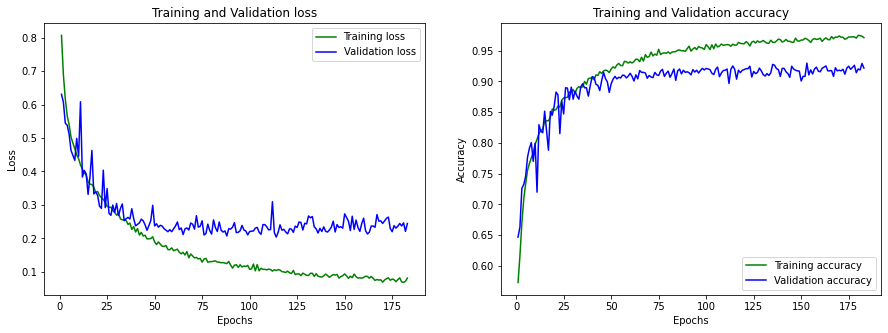

In [8]:
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,len(loss_val)+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1,len(acc_val)+1)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### Highest Accuracy Achieved: 92%